In [1]:
# imports
import numpy as np
import math

import sys as sys
import os
import tkinter as tk
from tkinter import filedialog

import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as plb

from skimage import io
from scipy.signal import argrelextrema, savgol_filter
from scipy.optimize import curve_fit
from scipy import exp
from astropy import modeling
#import warnings
#from scipy.optimize import OptimizeWarning

import time
import datetime as dt
import csv

%matplotlib inline

In [2]:
# options
zsave = True
zplot = True
zallplot = False

In [3]:
# metadata
x_pixel_size = 0.116  # um
y_pixel_size = 0.116  # um
avg_delta_t = input('Enter average frame time (from other code) in msec: ') # ms - get this by running the appropriate code on the corresponding metadata!
try:
    avg_delta_t = float(avg_delta_t)
    print('average frame time: {0} msec'.format(avg_delta_t))
except ValueError:
    print('Please enter a valid number')

num_px_x = input('Enter size of image in x (width) in pixels: ') # pixels
try:
    num_px_x = int(num_px_x)
    print('width of image: {0} pixels'.format(num_px_x))
except ValueError:
    print('Please enter a valid number')
num_px_y = input('Enter size of image in y (height) in pixels: ') # pixels
try:
    num_px_y = int(num_px_y)
    print('height of image: {0} pixels'.format(num_px_y))
except ValueError:
    print('Please enter a valid number')
min_cycle_length = 2 #5 # frames
max_cycle_length = 50 # frames; must be less than or equal number used in Fiji script
roi_size = 15 # pixels; must match that used in Fiji script

correlation_threshold = 0.05 #0.02 #

Enter average frame time (from other code) in msec:  14.0618617


average frame time: 14.0618617 msec


Enter size of image in x (width) in pixels:  235


width of image: 235 pixels


Enter size of image in y (height) in pixels:  152


height of image: 152 pixels


In [4]:
# function for debugging
def pause():
    programPause = input('Press <ENTER> to continue.')

In [5]:
root = tk.Tk()
root.withdraw()

directory = filedialog.askdirectory(title = 'choose folder with STICS data set format:.csv' ) 
os.chdir(directory)

In [6]:
# initialize
image_stack = np.empty(shape=(num_px_y,num_px_x))
#print(image_stack.shape)

period_map = np.zeros(shape=(num_px_y,num_px_x))
frequency_map = np.zeros(shape=(num_px_y,num_px_x))

frequency_list = []


In [7]:
def zslice_identifier(x):
    #print(x[-15:-10])
    return(x[-15:-10])
    #return(x[-1:-5]) #for Hetty movies

In [8]:
num_files = 0
all_files = os.listdir(directory)

for filename in sorted(all_files, key = zslice_identifier):
    
    if filename.endswith(".tif"):
        print(filename)
        num_files += 1
        temp_img = io.imread(filename)
        
        #imgplot = plt.imshow(temp_img)
        #plt.show()
        
        #check image properties
        image_size = temp_img.shape
        bit_depth = temp_img.dtype
        
        image_stack=np.dstack((image_stack, temp_img))
        
    #os.close(filename)
        
if num_files != max_cycle_length:
    print("Verify input metadata!")
    
print(image_stack.shape)

Pos0Pos0_STICS_map_c00_z0000_t0000.tif
Pos0Pos0_STICS_map_c00_z0001_t0000.tif
Pos0Pos0_STICS_map_c00_z0002_t0000.tif
Pos0Pos0_STICS_map_c00_z0003_t0000.tif
Pos0Pos0_STICS_map_c00_z0004_t0000.tif
Pos0Pos0_STICS_map_c00_z0005_t0000.tif
Pos0Pos0_STICS_map_c00_z0006_t0000.tif
Pos0Pos0_STICS_map_c00_z0007_t0000.tif
Pos0Pos0_STICS_map_c00_z0008_t0000.tif
Pos0Pos0_STICS_map_c00_z0009_t0000.tif
Pos0Pos0_STICS_map_c00_z0010_t0000.tif
Pos0Pos0_STICS_map_c00_z0011_t0000.tif
Pos0Pos0_STICS_map_c00_z0012_t0000.tif
Pos0Pos0_STICS_map_c00_z0013_t0000.tif
Pos0Pos0_STICS_map_c00_z0014_t0000.tif
Pos0Pos0_STICS_map_c00_z0015_t0000.tif
Pos0Pos0_STICS_map_c00_z0016_t0000.tif
Pos0Pos0_STICS_map_c00_z0017_t0000.tif
Pos0Pos0_STICS_map_c00_z0018_t0000.tif
Pos0Pos0_STICS_map_c00_z0019_t0000.tif
Pos0Pos0_STICS_map_c00_z0020_t0000.tif
Pos0Pos0_STICS_map_c00_z0021_t0000.tif
Pos0Pos0_STICS_map_c00_z0022_t0000.tif
Pos0Pos0_STICS_map_c00_z0023_t0000.tif
Pos0Pos0_STICS_map_c00_z0024_t0000.tif
Pos0Pos0_STICS_map_c00_z0

In [9]:
def find_nearest_two_val(array, value):
    array = np.asarray(array)
    idx = []
    
    idx.append((np.abs(array - value)).argmin())
    temp_array = np.empty_like(array)
    temp_array[:] = array
    temp_array[idx[0]] = 100000 #ignore this index
    idx.append((np.abs(temp_array - value)).argmin())
    round_num = 0
    test_val = (array[idx[0]]-value)*(array[idx[1]]-value)
    while test_val > 0:
        if round_num > 10:
            return idx[0]
        else:
            temp_array[idx[1]] = 100000 #ignore this index
            idx[1] = (np.abs(temp_array - value)).argmin()
            test_val = (array[idx[0]]-value)*(array[idx[1]]-value)
            round_num += 1
    return sorted(idx)

In [10]:
for i in range(0,num_px_x):
    for j in range(0,num_px_y):
        delta_t = []
        correlation = []
        for k in range(0,max_cycle_length):
            delta_t.append(k)
            correlation.append(image_stack[j,i,k])
            
            if k == max_cycle_length-1:
                
                delta_t = np.array(delta_t)
                correlation = np.array(correlation)
                
                correlation[np.isnan(correlation)] = 0
                correlation[np.isinf(correlation)] = 1
                #correlation[-np.isinf(correlation)] = -1
                
                #window length for savitzky-golay filter must be odd, so round up 1 if min_cycle_length is even
                if (min_cycle_length % 2) == 0:
                    window_length = min_cycle_length + 1
                else:
                    window_length = min_cycle_length
                
                #print(correlation)

                filt_correlation = savgol_filter(correlation, window_length, 1) #min_cycle_length defines window size, polynomial order 3
                
                if correlation[correlation > correlation_threshold].size > 3:
                    local_min_ind = argrelextrema(filt_correlation,np.less)[0]
                    #local_min_ind = local_min_ind[0]#[local_min_ind[0] > min_cycle_length] #ignore first few frames
                    local_max_ind = argrelextrema(filt_correlation,np.greater)
                    local_max_ind = local_max_ind[0][local_max_ind[0] > min_cycle_length] #ignore first few frames
                    local_max_ind = local_max_ind[local_max_ind > correlation_threshold] #ensure maxima are large enough
                    approx_max_ind = local_max_ind[0] #delta_t[filt_correlation==np.amax(filt_correlation[local_max_ind])]
                    ind_of_ind = find_nearest_two_val(local_min_ind, approx_max_ind)
                    
                    if type(ind_of_ind) != np.int64: #two valid minima found
                        minima_for_fit = [local_min_ind[ind_of_ind[0]]+1,local_min_ind[ind_of_ind[1]]-1]

                        if correlation[approx_max_ind] > correlation_threshold:
                            x = np.empty_like(delta_t[minima_for_fit[0]:minima_for_fit[1]])
                            x[:] = delta_t[minima_for_fit[0]:minima_for_fit[1]]
                            y = np.empty_like(correlation[minima_for_fit[0]:minima_for_fit[1]])
                            y[:] = correlation[minima_for_fit[0]:minima_for_fit[1]]
                            
                            if len(x) > min_cycle_length: #proceed with fit only if sufficient temporal resolution
                                
                                #remove offset
                                offset = y.min()
                                y-=offset

                                fitter = modeling.fitting.LevMarLSQFitter()
                                initial_gaussian = modeling.models.Gaussian1D(amplitude= max(y), mean=approx_max_ind, stddev=min_cycle_length/2) #approx_max_ind-minima_for_fit[0])   # initial guess
                                #print(initial_gaussian)
                                #print(x)
                                #print(y)
                                fitted_gaussian = fitter(initial_gaussian, x, y)
                                #parameters are amplitude, mean, stddev
                                #mean is cycle duration of one period in frames as it gives you the first peak after delta_t=0 (image correlated with itself) and hence how long it takes to look most like the original image again
                                period = 0
                                period = fitted_gaussian.parameters[1]

    #                            popt = gaussian_fit(x,y, correlation_threshold, min_cycle_length)
    #                            if type(popt) != str:
                                    #popt is parameters of gaussian: popt[0] is offset, popt[1] is amplitude, popt[2] is mean, popt[3] is sigma
                                    #mean is cycle duration of one period in frames as it gives you the first peak after delta_t=0 (image correlated with itself) and hence how long it takes to look most like the original image again
    #                                period = 0
    #                                period = popt[2] # in frames
    #                                frequency = 0;
    #                                frequency = 1/(period*(avg_delta_t/1000)) # converted to Hz
    #                                period_map[j-round(roi_size/2):j+round(roi_size/2),i-round(roi_size/2):i+round(roi_size/2)] = period
    #                                frequency_map[j-round(roi_size/2):j+round(roi_size/2),i-round(roi_size/2):i+round(roi_size/2)] = frequency

                                frequency = 0;
                                frequency = 1/(period*(avg_delta_t/1000)) # converted to Hz
                                period_map[j-round(roi_size/2):j+round(roi_size/2),i-round(roi_size/2):i+round(roi_size/2)] = period
                                frequency_map[j-round(roi_size/2):j+round(roi_size/2),i-round(roi_size/2):i+round(roi_size/2)] = frequency

                                frequency_list.append(frequency)

                                if zallplot == True:
                                    #%matplotlib inline

                                    #plot of frequencies
                                    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

                                    ax.plot(delta_t, correlation, color='blue', linestyle='dashed',linewidth=2, markersize=12)   
                                    ax.plot(delta_t, filt_correlation, color='red', linestyle='dashed',linewidth=2, markersize=12)
                                    ax.plot(delta_t[minima_for_fit], filt_correlation[minima_for_fit], 'rx')
                                    ax.plot(delta_t[approx_max_ind], filt_correlation[approx_max_ind], 'bx')
                                    ax.plot(delta_t[local_min_ind], filt_correlation[local_min_ind], 'rd')
                                    ax.plot(delta_t[local_max_ind], filt_correlation[local_max_ind], 'bd')

    #                                if type(popt) != str:
    #                                    plot_x = np.linspace(x[0],x[-1], 200)
                                        #ax.plot(plot_x, offset+gaussian(plot_x, popt[0], popt[1], popt[2], popt[3]), color='black', linestyle='solid',linewidth=2, markersize=12)
                                        #ax.plot(plot_x, offset+gaussian(plot_x, popt[0], popt[1], popt[2]), color='black', linestyle='solid',linewidth=2, markersize=12)
                                        #ax.plot(plot_x, gaussian(plot_x, popt[0], popt[1], popt[2]), color='black', linestyle='solid',linewidth=2, markersize=12)
    #                                    ax.plot(plot_x, gaussian(plot_x, popt[0], popt[1], popt[2], popt[3]), color='black', linestyle='solid',linewidth=2, markersize=12)

                                    plot_x = np.linspace(x[0],x[-1], 200)
                                    ax.plot(plot_x, offset+fitted_gaussian(plot_x), color='black', linestyle='solid',linewidth=2, markersize=12)
                                    ax.plot(fitted_gaussian.parameters[1], 0, 'kx')

                                    ax.set_ylim(-1,1)
                                    ax.set_title("Correlation in ROI", fontsize=12)
                                    ax.set_ylabel("Correlation", fontsize=12)
                                    ax.set_xlabel("Time lag", fontsize=12)

                                    plt.tight_layout()


                                    # save fig
                                    if zsave == True:
                                        #script_dir = os.path.abspath('..') #os.path.dirname('..')
                                        results_dir = os.path.join(directory, 'Results/')
                                        file_name = 'Fitted_z-profile_correlation_{}_{}_{}.png'.format(i,j,dt.datetime.now().strftime('%Y%m%d%H%M%S'))
                                        if not os.path.isdir(results_dir):    
                                            os.makedirs(results_dir)
                                        plt.savefig(results_dir + file_name,dpi=130)
                                    plt.show()

                                #print("amplitude: " + str(fitted_gaussian.parameters[0]))
                                #print("mean: " + str(fitted_gaussian.parameters[1]))
                                #print("standard deviation: " + str(fitted_gaussian.parameters[2]))

print('done fitting')

done fitting


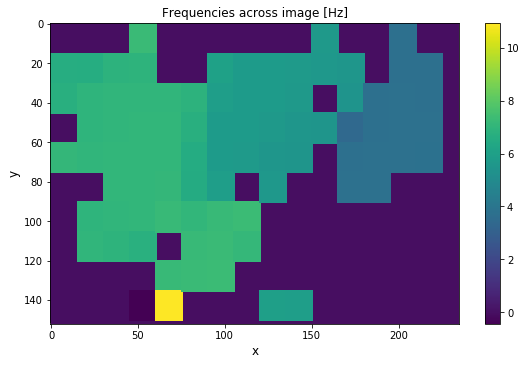

In [11]:
if zplot == True:
    
    #%matplotlib inline

    #plot of frequencies
    img_height = 8
    img_width = img_height*num_px_y/num_px_x
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(img_height, img_width))
    
    #print(np.nanmin(frequency_map))
    #print(np.nanmax(frequency_map))
    #color_lim = (np.amin(frequency_map),np.amax(frequency_map))
    color_lim = (np.nanmin(frequency_map),np.nanmax(frequency_map))

    ax.imshow(frequency_map, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]))
    ax.set_title("Frequencies across image [Hz]", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_xlabel("x", fontsize=12)
    pcm = ax.pcolormesh(frequency_map,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')
    fig.colorbar(pcm, ax=ax)

    plt.tight_layout()

    # save fig
    if zsave == True:
        #script_dir = os.path.abspath('..') #os.path.dirname('..')
        results_dir = os.path.join(directory, 'Results/')
        file_name = 'Frequency_map_{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
        if not os.path.isdir(results_dir):    
            os.makedirs(results_dir)
        plt.savefig(results_dir + file_name,dpi=130)

    plt.show()

In [12]:
if zsave == True:
    
    #save_freq = np.empty_like(frequency_map.ravel()[np.flatnonzero(frequency_map)])
    #save_freq[:] = frequency_map.ravel()[np.flatnonzero(frequency_map)]
    save_freq = np.asarray(frequency_list)
    
    results_dir = os.path.join(directory, 'Results/')
    #file_name = 'Frequency_list_{}.csv'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    file_name = 'Frequency_list.csv'
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    
    np.savetxt(results_dir + file_name, save_freq, delimiter=',', newline='\n', fmt='%f')
    
    #writer= csv.writer(results_dir+file_name, delimiter=',')
    #for x in np.nditer(save_freq.T, order='C'): 
    #    row.append(str(x))
    #    writer.writerow(row)

In [13]:
print('done')

done


In [10]:
def gaussian(x, offset, amp, x0, sigma):
#def gaussian(x, amp, x0, sigma):
    return offset + amp * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
    #return amp * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gaussian_fit(x, y, correlation_threshold, min_cycle_length):
    #mean = sum(x * y) / sum(y)
    #sig = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    
    n = x.size #len(x)
    mean = (x[-1]-x[0])/2 #sum(x*y)/n
    sig = (x[-1]-x[0])/2 #math.sqrt(sum((x-mean)**2)/(n-1))
    #sig = sum(y*(x-mean)**2)/n
    
    print("estimated offset: " + str(np.amin(y)))
    min_offset = np.amin(y)-1
    print("offset min: " + str(min_offset))
    max_offset = np.amin(y) + (np.amax(y)-np.amin(y))/2
    print("offset max: " + str(max_offset))
    print("estimated amplitude: " + str(np.amax(y)))
    min_amp = np.amin(y)+correlation_threshold
    print("amplitude min: " + str(min_amp))
    max_amp = 1 #np.amax(y)
    print("amplitude max: " + str(max_amp))
    print("estimated mean: " + str(mean))
    min_mean = x[0]
    print("mean min: " + str(min_mean))
    max_mean = x[-1]
    print("mean max: " + str(max_mean))
    print("estimated sigma: " + str(sig))
    min_sig = mean/10 #min_cycle_length/4
    print("sigma min: " + str(min_sig))
    max_sig = (x[-1]-x[0])
    print("sigma max: " + str(max_sig))
    
    with warnings.catch_warnings():
        warnings.simplefilter("error", ValueError) #OptimizeWarning)
        try:
            popt, pcov = curve_fit(gaussian, x, y, p0=[min(y), max(y), mean, sig])
            #popt, pcov = curve_fit(gaussian, x, y, p0=[max(y), mean, sig]) #, bounds = ((min_amp,0,min_sig), (max_amp,np.inf,max_sig)))
            #popt, pcov = curve_fit(gaussian, x, y, p0=[min(y), max(y), mean, sig], bounds = ((min_offset,min_amp,0,min_sig), (max_offset,max_amp,np.inf,max_sig)))

            return popt
        #except OptimizeWarning:
            #return "Could not fit Gaussian"
        except ValueError:
            return "Could not fit Gaussian"